PDF

 ├── Text → Text Summary → Embeddings

 ├── Tables → Table Summary → Embeddings

 └── Images → Vision Summary → Embeddings

↓                      
Multimodal RAG

                                      MultiVision RAG

https://drive.google.com/file/d/1Ub4LqAH8YoO5aHsD4wONT5UoLyj9Cpn3/view?usp=sharing

In [1]:
! gdown 1Ub4LqAH8YoO5aHsD4wONT5UoLyj9Cpn3

Downloading...
From: https://drive.google.com/uc?id=1Ub4LqAH8YoO5aHsD4wONT5UoLyj9Cpn3
To: /content/attention.pdf
100% 2.22M/2.22M [00:00<00:00, 106MB/s]


In [11]:
! pip install -U \
chromadb==1.4.1 \
fastapi==0.128.0 \
ipython==8.37.0 \
langchain==1.0.1 \
langchain-classic==1.0.1 \
langchain-community==0.4.1 \
langchain-core==1.2.7 \
langchain-huggingface==1.2.0 \
langchain-openai==1.1.7 \
langchain-pinecone==0.2.13 \
langchain-text-splitters==1.1.0 \
opencv-python==4.13.0.92 \
pillow==12.1.0 \
pinecone==7.3.0 \
pypdf==6.6.2 \
pytesseract==0.3.13 \
python-dotenv==1.2.1 \
unstructured==0.18.31

  Using cached langchain_pinecone-0.2.13-py3-none-any.whl.metadata (8.6 kB)
  Using cached pinecone-7.3.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached pinecone_plugin_assistant-1.8.0-py3-none-any.whl.metadata (30 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.9/831.9 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.7 MB/s eta 0:00:00
Using cached langchain_pinecone-0.2.13-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
! pip freeze

absl-py==1.4.0
accelerate==1.12.0
access==1.1.10.post3
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.3
aiohttp-retry==2.9.1
aiosignal==1.4.0
aiosqlite==0.22.1
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.18.4
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.1
anywidget==0.9.21
apsw==3.51.2.0
apswutils==0.1.2
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2026.2.16.0.48.25
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.8
autograd==1.8.0
babel==2.18.0
backcall==0.2.0
backoff==2.2.1
bcrypt==5.0.0
beartype==0.22.9
beautifulsoup4==4.14.3
betterproto==2.0.0b6
bigframes==2.35.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.2.0
blosc2==4.0.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
build==1.4.0
CacheControl==

In [ ]:
import os

# keys for the services we will use
OPENAI_API_KEY = "sk---.."

os.environ["GROQ_API_KEY"] = "sk-..."

PINECONE_API_KEY = "pc..."
pinecone_api_key = PINECONE_API_KEY


In [ ]:
# inspect_rag_response(response)



=== TEXT CHUNKS ===

[Chunk 1] Type: text, Page: N/A
3.2.2 Multi-Head Attention

Instead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional

‘To illustrate why the dot products get large, assume that the components of g and k are independent random variables with mean 0 and variance 1. Then their dot product, g -k = vt qiki, has mean 0 and variance d,.

4

output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averagi

# VisionRAG AI

### 1️⃣ PDF Partitioning

In [1]:
from unstructured.partition.pdf import partition_pdf
import os

output_path = "medicalai/data/"
# output_path = "/content/"
os.makedirs(output_path, exist_ok=True)
file_path = os.path.join(output_path, "attention.pdf")

chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
)


/home/ahmed/miniconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


### 2️⃣ Separate Texts, Tables, Images

In [2]:
from unstructured.documents.elements import Table, CompositeElement, Image

texts, tables = [], []

for el in chunks:
    if isinstance(el, CompositeElement):
        texts.append(el)
    elif isinstance(el, Table):
        tables.append(el)




### 3️⃣ Extract Images (Base64)

In [3]:
def get_images_base64(chunks):
    images = []
    for chunk in chunks:
        if isinstance(chunk, CompositeElement):
            for el in chunk.metadata.orig_elements:
                if isinstance(el, Image) and el.metadata.image_base64:
                    images.append(el.metadata.image_base64)
    return images

images = get_images_base64(chunks)


### 4️⃣ Text & Table Summarization (FIXED)

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0.3,
    api_key=OPENAI_API_KEY
)

SUMMARY_PROMPT = """
Produce a concise, factual summary.
Preserve key facts and numbers.
Output ONLY the summary text.

Content:
{element}
"""

summary_prompt = ChatPromptTemplate.from_template(SUMMARY_PROMPT)

summarization_chain = (
    {"element": lambda x: x}
    | summary_prompt
    | llm
    | StrOutputParser()
)

def summarize_batch(elements, chain, max_concurrency=3):
    return chain.batch(elements, {"max_concurrency": max_concurrency})

# ✅ FIX: convert CompositeElement → text
text_elements = [t.text for t in texts]
text_summaries = summarize_batch(text_elements, summarization_chain)

tables_html = [t.metadata.text_as_html for t in tables]
table_summaries = summarize_batch(tables_html, summarization_chain)


In [8]:
# text_elements

### 5️⃣ Image Summarization (FIXED & SINGLE)

In [7]:
VISION_PROMPT = """
Describe the image precisely.
Do not speculate.
"""

vision_prompt = ChatPromptTemplate.from_messages([
    (
        "user",
        [
            {"type": "text", "text": VISION_PROMPT},
            {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image}"}}
        ],
    )
])

vision_chain = (
    {"image": lambda x: x}
    | vision_prompt
    | llm
    | StrOutputParser()
)

image_summaries = vision_chain.batch(images, {"max_concurrency": 2})


### 6️⃣ Vectorstore + Docstore Setup

In [ ]:
import uuid
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_classic.storage.in_memory import InMemoryStore
from langchain_classic.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.vectorstores import Chroma
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore


index_name = "vision-rag"
cloud = "aws"
region = "us-east-1"
dimension = 1536
pinecone_api_key = "p...."


embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=OPENAI_API_KEY
)

pc = Pinecone(api_key=pinecone_api_key)
if index_name not in pc.list_indexes():
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud=cloud, region=region)
    )

vectorstore = PineconeVectorStore(
    index_name=index_name,
    embedding=embeddings,
)

# vectorstore = Chroma(
#     collection_name="multi_collection",
#     embedding_function=embeddings,
#     persist_directory="./chroma_db"
# )

store = InMemoryStore()
print(f"Vector store for '{index_name}' is ready ✅")


Vector store for 'vision-rag' is ready ✅


In [14]:
import pinecone
print(dir(pinecone))

['Admin', 'AwsRegion', 'AzureRegion', 'BackupList', 'BackupModel', 'ByocSpec', 'CloudProvider', 'CollectionDescription', 'CollectionList', 'Config', 'ConfigBuilder', 'ConfigureIndexEmbed', 'CreateIndexForModelEmbedTypedDict', 'DeleteRequest', 'DeletionProtection', 'DescribeIndexStatsRequest', 'DescribeIndexStatsResponse', 'EmbedModel', 'EmbeddingsList', 'FetchResponse', 'ForbiddenException', 'GcpRegion', 'ImportErrorMode', 'IndexEmbed', 'IndexList', 'IndexModel', 'ListConversionException', 'Metric', 'ModelInfo', 'ModelInfoList', 'NamespaceDescription', 'NotFoundException', 'Pinecone', 'PineconeApiAttributeError', 'PineconeApiException', 'PineconeApiKeyError', 'PineconeApiTypeError', 'PineconeApiValueError', 'PineconeAsyncio', 'PineconeConfig', 'PineconeConfigurationError', 'PineconeException', 'PineconeProtocolError', 'PodIndexEnvironment', 'PodSpec', 'PodSpecDefinition', 'PodType', 'QueryRequest', 'QueryResponse', 'RerankModel', 'RerankResult', 'RestoreJobList', 'RestoreJobModel', 'Rp

### 7️⃣ Add Documents to RAG (FIXED)

In [15]:
import uuid
from langchain_core.documents import Document

def add_to_rag(summary: str, original_content, doc_type: str):
    """
    summary         -> vector DB (searchable)
    original_content-> docstore (text / table / image base64)
    """

    doc_id = str(uuid.uuid4())

    # 🔹 Vectorstore: only summary
    vectorstore.add_documents([
        Document(
            page_content=summary,
            metadata={"doc_id": doc_id, "type": doc_type}
        )
    ])

    # 🔹 Docstore: original content
    if doc_type == "image":
        content = original_content            # base64
    elif hasattr(original_content, "text"):
        content = original_content.text       # CompositeElement
    else:
        content = str(original_content)       # table html / string

    store.mset([
        (
            doc_id,
            Document(
                page_content=content,
                metadata={"doc_id": doc_id, "type": doc_type}
            )
        )
    ])



### 8️⃣ Store Everything (CORRECT)

In [16]:
for s, t in zip(text_summaries, text_elements):
    add_to_rag(s, t, "text")

for s, t in zip(table_summaries, tables_html):
    add_to_rag(s, t, "table")

# # ✅ FIX: store IMAGE SUMMARY, not base64
# for s in image_summaries:
#     add_to_rag(s, s, "image")

# image_summaries -> LLM-generated text
# images          -> base64 images

for img_summary, img_b64 in zip(image_summaries, images):
    add_to_rag(
        summary=img_summary,        # 🔍 searchable
        original_content=img_b64,   # 🖼️ visible
        doc_type="image"
    )



### 9️⃣ Retriever

In [17]:
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key="doc_id"
)

retriever.search_kwargs = {"k": 2}


### 🔟 Build Prompt

In [18]:
from langchain_core.prompts import ChatPromptTemplate

def build_prompt(context, question):
    context_text = ""

    for doc in context["texts"]:
        context_text += doc.page_content + "\n"

    prompt = ChatPromptTemplate.from_template("""
Answer ONLY using the context below.
If the answer is not present, say "Not found in the document."

Context:
{context}

Question:
{question}
""")

    return prompt, {
        "context": context_text,
        "question": question
    }



### 1️⃣1️⃣ Query RAG

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0.3,
    api_key=OPENAI_API_KEY
)

def query_rag(question):
    docs = retriever.invoke(question)
    parsed = parse_docs(docs)

    prompt, inputs = build_prompt(parsed, question)
    messages = prompt.format_prompt(**inputs).to_messages()

    response = llm.invoke(messages)

    return response.content, parsed



from base64 import b64decode

def parse_docs(docs):
    images = []
    texts = []

    for doc in docs:
        doc_id = doc.metadata.get("doc_id")
        if not doc_id:
            continue

        original = store.mget([doc_id])[0]
        if not original:
            continue

        if original.metadata["type"] == "image":
            try:
                b64decode(original.page_content)
                images.append(original.page_content)
            except Exception:
                pass
        else:
            texts.append(original)

    return {
        "images": images,   # base64
        "texts": texts      # Document objects
    }



from IPython.display import display, Image
from base64 import b64decode

def show_images(images):
    for idx, img in enumerate(images, 1):
        print(f"🖼️ Image {idx}")
        display(Image(data=b64decode(img)))



In [32]:
question = "the multi-head attention"

answer, context = query_rag(question)

# 🔥 Show matched images
show_images(context["images"])

# 🧠 Show answer
print("\n=== ANSWER ===\n")
print(answer)




=== ANSWER ===

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions by projecting queries, keys, and values h times with learned linear projections, performing attention in parallel on each, and then concatenating and projecting the results.


In [28]:
context

{'images': [],
 'texts': [Document(metadata={'doc_id': '3bced3a1-30cd-44c5-94cb-9669e95ccd7e', 'type': 'text'}, page_content='3.2.2 Multi-Head Attention\n\nInstead of performing a single attention function with dmodel-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values h times with different, learned linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional\n\n*To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, g -k = ve, qik;, has mean 0 and variance d,.\n\n4\n\noutput values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.\n\nMulti-head attention allows the model to jointly attend to information from different rep

🖼️ Image 1


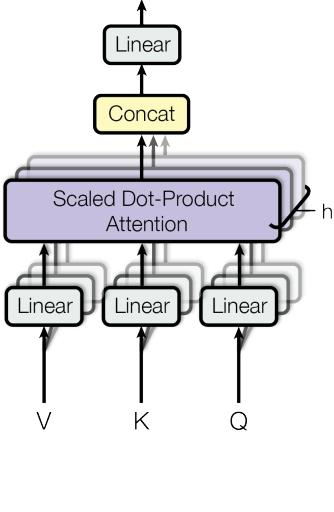

🖼️ Image 2


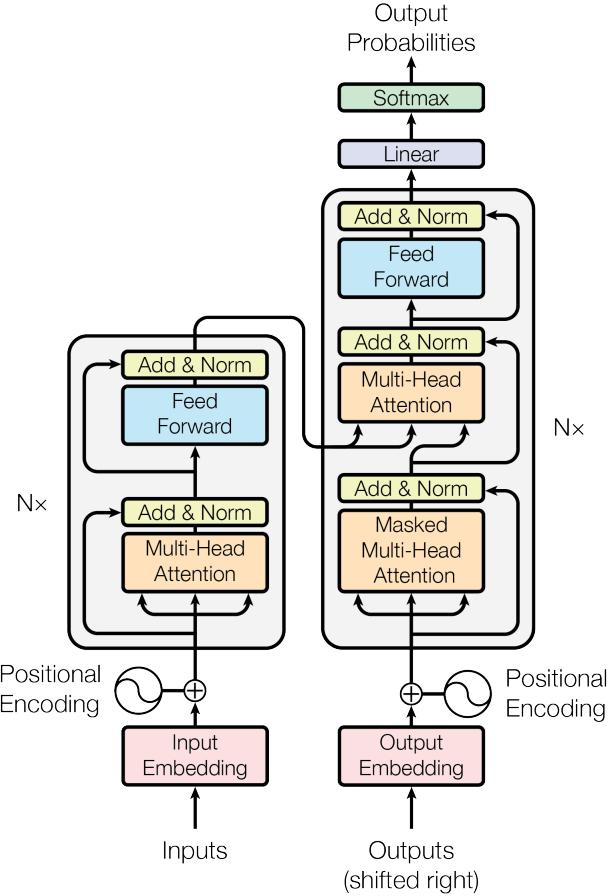


=== ANSWER ===

Not found in the document.


In [23]:
question = "Explain the Atention Visualisation diagram"

answer, context = query_rag(question)

# 🔥 Show matched images
show_images(context["images"])

# 🧠 Show answer
print("\n=== ANSWER ===\n")
print(answer)


In [24]:
question = "Explain Training Data and Batch"

answer, context = query_rag(question)
print(answer)

The training data consisted of the standard WMT 2014 English-German dataset with about 4.5 million sentence pairs, encoded using byte-pair encoding with a shared vocabulary of approximately 37,000 tokens. For English-French, the dataset was larger, comprising 36 million sentences, with tokens split into a 32,000-word-piece vocabulary. Sentence pairs were batched together based on approximate sequence length, with each batch containing roughly 25,000 source tokens and 25,000 target tokens.


In [25]:
context

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK49fE2t69eXEfhbTrOSwtpWhfUr+Zlil

🖼️ Image 1


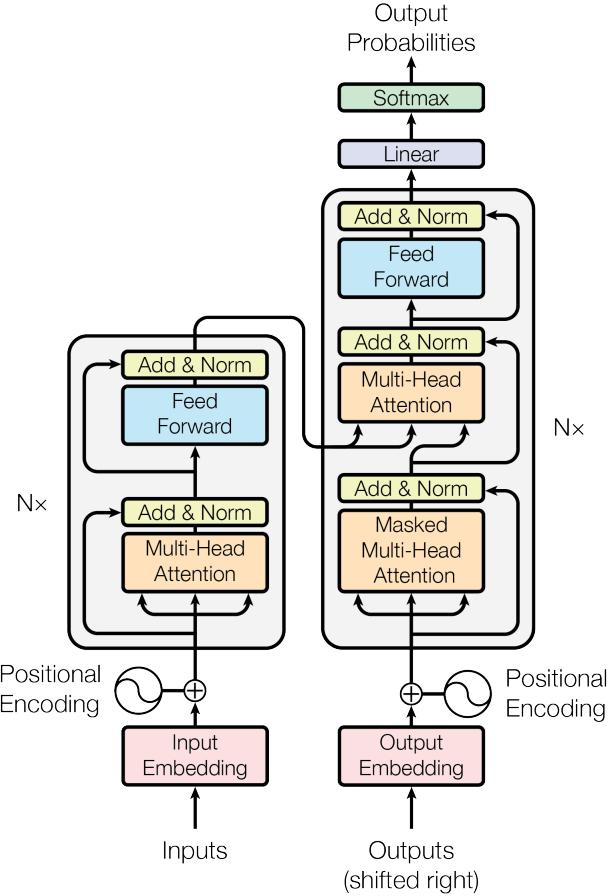

In [26]:
# 🔥 Show matched images
show_images(context["images"])